# TAPAS fine-tuned on spider then QATCH synthetic data generated from proprietary tables from Kaggle in different domains (medicine)

Training set: 344  
Validation set: 42  
Testing set: 43

Distribution of the data generated by QATCH, stratified split:  
**sql_tags**  

sql_tags  
HAVING: 149  
WHERE: 77  
SELECT: 32  
ORDER BY: 26  
SIMPLE: 25  
GROUP BY: 22  
DISTINCT: 13  

The model performs worst in categories with scarce data. I couldn't adjust the training set each time based on previous model performance because QATCH does not allow the generation of curated samples.

The models were trained for a maximum of 25 epochs. We checkpoint the best validation loss at each epoch and implement early stopping if the validation loss stagnates. The learning rate is dynamically adjusted based on the validation loss.

I noticed that models trained for longer periods tend to forget the Spider fine-tuning. There is a trade-off here. Stop training at a point where we are satisfied with the performance and not just the performance on proprietary data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from google.colab import drive
from scipy.interpolate import PchipInterpolator



# Function to create a smooth curve using Pchip
def smooth_curve(x, y):
    pchip_interp = PchipInterpolator(x, y)
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = pchip_interp(x_smooth)
    return x_smooth, y_smooth

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


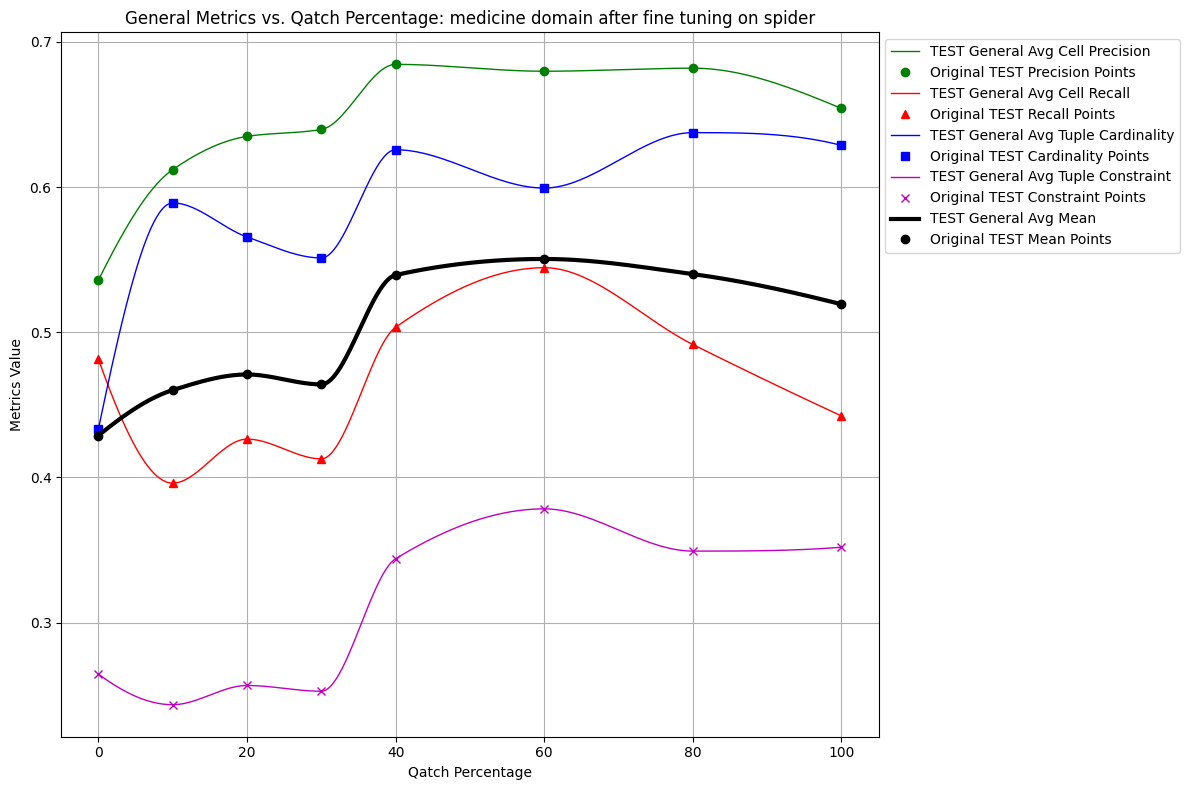

In [ ]:
#@title Medicine results after fine tuning on spider learning rate 1e-5

base_path = '/content/drive/MyDrive/Tapas_SpiderPlusQatchProprietary_Logs/Medicine/results_gpt4o/'
filename_pattern = '{}prct_gpt4o_medicine_10_epochs_lr_1e-5_test.csv'
percentages = [0,10,20,30,40,60,80,100]

combined_df_MedicineQatch = pd.DataFrame()
first_file_structure = None

for pct in percentages:
    file_path = os.path.join(base_path, filename_pattern.format(pct))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    current_df = pd.read_csv(file_path)
    current_df['qatch_percentage'] = pct
    if first_file_structure is None:
        first_file_structure = current_df.columns.tolist()
    else:
        if current_df.columns.tolist() != first_file_structure:
            print(f"File structure mismatch, skipping file: {file_path}")
            continue
    combined_df_MedicineQatch = pd.concat([combined_df_MedicineQatch, current_df], ignore_index=True)


columns_for_mean = ['general_avg_cell_precision', 'general_avg_cell_recall', 'general_avg_tuple_cardinality', 'general_avg_tuple_constraint']
combined_df_MedicineQatch['general_avg_mean'] = combined_df_MedicineQatch[columns_for_mean].mean(axis=1)



plt.figure(figsize=(12, 8))

# Ensure your data is sorted by 'qatch_percentage'
combined_df_MedicineQatch = combined_df_MedicineQatch.sort_values('qatch_percentage')
combined_df_MedicineQatch_Low_Lr=combined_df_MedicineQatch.copy()

# TEST data
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_precision'])
plt.plot(x_smooth, y_smooth, 'g-', label='TEST General Avg Cell Precision', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_precision'], 'go', label='Original TEST Precision Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_recall'])
plt.plot(x_smooth, y_smooth, 'r-', label='TEST General Avg Cell Recall', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_recall'], 'r^', label='Original TEST Recall Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_cardinality'])
plt.plot(x_smooth, y_smooth, 'b-', label='TEST General Avg Tuple Cardinality', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_cardinality'], 'bs', label='Original TEST Cardinality Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_constraint'])
plt.plot(x_smooth, y_smooth, 'm-', label='TEST General Avg Tuple Constraint', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_constraint'], 'mx', label='Original TEST Constraint Points')

# Plot the new column with more emphasis (e.g., thicker line)
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'])
plt.plot(x_smooth, y_smooth, 'k-', label='TEST General Avg Mean', lw=3)  # Increase line width for emphasis
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'], 'ko', label='Original TEST Mean Points')



plt.title('General Metrics vs. Qatch Percentage: medicine domain after fine tuning on spider')
plt.xlabel('Qatch Percentage')
plt.ylabel('Metrics Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()

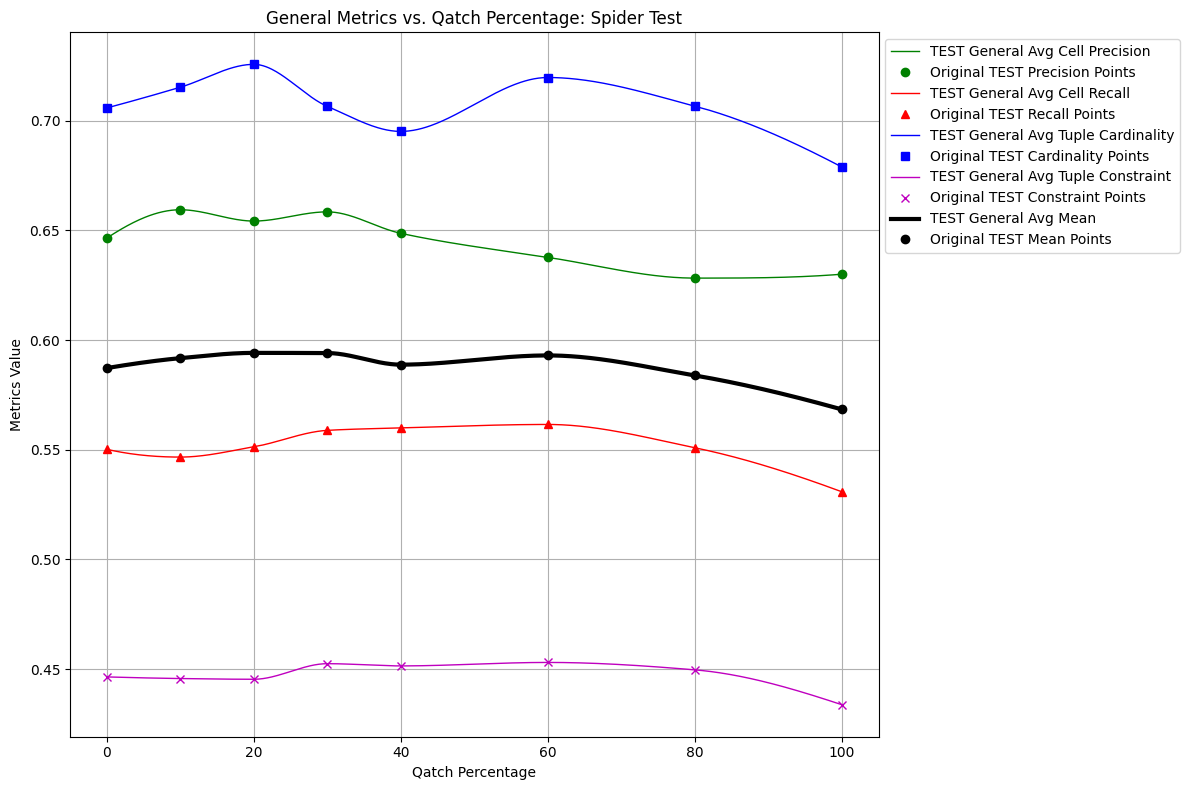

In [ ]:
#@title Spider test results after fine tuning on Medicine
base_path = '/content/drive/MyDrive/Tapas_SpiderPlusQatchProprietary_Logs/Medicine/results_gpt4o/'
filename_pattern = 'SpiderDev_gpt4o_lr1e-5_10epochs_{}prt.csv'
percentages = [0,10, 20, 30,40,60,80,100]

combined_df_Medicine = pd.DataFrame()
first_file_structure = None

for pct in percentages:
    file_path = os.path.join(base_path, filename_pattern.format(pct))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    current_df = pd.read_csv(file_path)
    current_df['qatch_percentage'] = pct
    if first_file_structure is None:
        first_file_structure = current_df.columns.tolist()
    else:
        if current_df.columns.tolist() != first_file_structure:
            print(f"File structure mismatch, skipping file: {file_path}")
            continue
    combined_df_Medicine = pd.concat([combined_df_Medicine, current_df], ignore_index=True)


columns_for_mean = ['general_avg_cell_precision', 'general_avg_cell_recall', 'general_avg_tuple_cardinality', 'general_avg_tuple_constraint']
combined_df_Medicine['general_avg_mean'] = combined_df_Medicine[columns_for_mean].mean(axis=1)


#@title Spider test
plt.figure(figsize=(12, 8))

# Ensure your data is sorted by 'qatch_percentage'
combined_df_Medicine = combined_df_Medicine.sort_values('qatch_percentage')
combined_df_Medicine_Low_Lr=combined_df_Medicine.copy()

# TEST data
x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_precision'])
plt.plot(x_smooth, y_smooth, 'g-', label='TEST General Avg Cell Precision', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_precision'], 'go', label='Original TEST Precision Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_recall'])
plt.plot(x_smooth, y_smooth, 'r-', label='TEST General Avg Cell Recall', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_recall'], 'r^', label='Original TEST Recall Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_cardinality'])
plt.plot(x_smooth, y_smooth, 'b-', label='TEST General Avg Tuple Cardinality', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_cardinality'], 'bs', label='Original TEST Cardinality Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_constraint'])
plt.plot(x_smooth, y_smooth, 'm-', label='TEST General Avg Tuple Constraint', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_constraint'], 'mx', label='Original TEST Constraint Points')

# Plot the new column with more emphasis (e.g., thicker line)
x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'])
plt.plot(x_smooth, y_smooth, 'k-', label='TEST General Avg Mean', lw=3)  # Increase line width for emphasis
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'], 'ko', label='Original TEST Mean Points')


plt.title('General Metrics vs. Qatch Percentage: Spider Test')
plt.xlabel('Qatch Percentage')
plt.ylabel('Metrics Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()

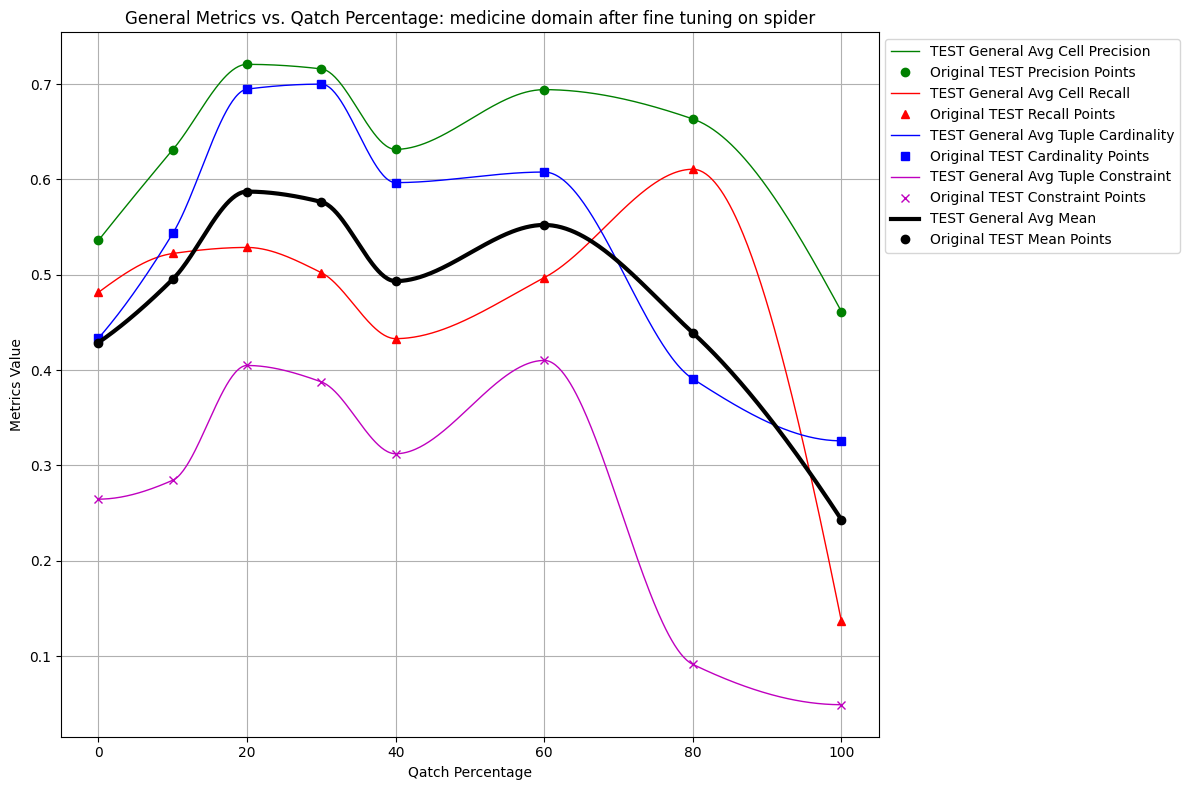

In [ ]:
#@title Medicine results after fine tuning on spider learning rate 5e-5

base_path = '/content/drive/MyDrive/Tapas_SpiderPlusQatchProprietary_Logs/Medicine/results_gpt4o/'
filename_pattern = '{}prct_gpt4o_medicine_10_epochs_lr_10e5_test.csv'
percentages = [0,10,20,30,40,60,80,100]

combined_df_MedicineQatch = pd.DataFrame()
first_file_structure = None

for pct in percentages:
    file_path = os.path.join(base_path, filename_pattern.format(pct))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    current_df = pd.read_csv(file_path)
    current_df['qatch_percentage'] = pct
    if first_file_structure is None:
        first_file_structure = current_df.columns.tolist()
    else:
        if current_df.columns.tolist() != first_file_structure:
            print(f"File structure mismatch, skipping file: {file_path}")
            continue
    combined_df_MedicineQatch = pd.concat([combined_df_MedicineQatch, current_df], ignore_index=True)


columns_for_mean = ['general_avg_cell_precision', 'general_avg_cell_recall', 'general_avg_tuple_cardinality', 'general_avg_tuple_constraint']
combined_df_MedicineQatch['general_avg_mean'] = combined_df_MedicineQatch[columns_for_mean].mean(axis=1)



plt.figure(figsize=(12, 8))

# Ensure your data is sorted by 'qatch_percentage'
combined_df_MedicineQatch = combined_df_MedicineQatch.sort_values('qatch_percentage')
combined_df_MedicineQatch_High_Lr=combined_df_MedicineQatch.copy()
# TEST data
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_precision'])
plt.plot(x_smooth, y_smooth, 'g-', label='TEST General Avg Cell Precision', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_precision'], 'go', label='Original TEST Precision Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_recall'])
plt.plot(x_smooth, y_smooth, 'r-', label='TEST General Avg Cell Recall', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_recall'], 'r^', label='Original TEST Recall Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_cardinality'])
plt.plot(x_smooth, y_smooth, 'b-', label='TEST General Avg Tuple Cardinality', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_cardinality'], 'bs', label='Original TEST Cardinality Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_constraint'])
plt.plot(x_smooth, y_smooth, 'm-', label='TEST General Avg Tuple Constraint', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_constraint'], 'mx', label='Original TEST Constraint Points')

# Plot the new column with more emphasis (e.g., thicker line)
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'])
plt.plot(x_smooth, y_smooth, 'k-', label='TEST General Avg Mean', lw=3)  # Increase line width for emphasis
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'], 'ko', label='Original TEST Mean Points')



plt.title('General Metrics vs. Qatch Percentage: medicine domain after fine tuning on spider')
plt.xlabel('Qatch Percentage')
plt.ylabel('Metrics Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()

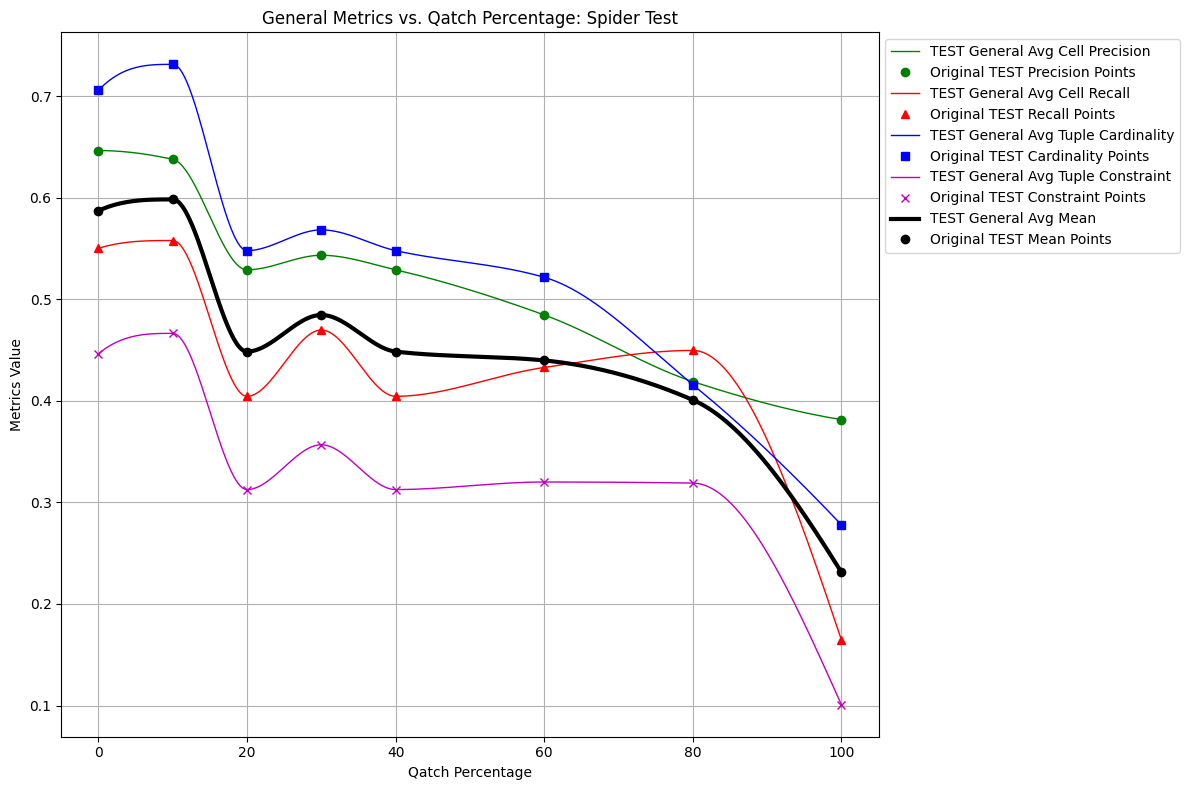

In [ ]:
#@title Spider test results after fine tuning on Medicine learning rate 5e-5
base_path = '/content/drive/MyDrive/Tapas_SpiderPlusQatchProprietary_Logs/Medicine/results_gpt4o/'
filename_pattern = 'SpiderDev_gpt4o_lr10e5_10epochs_{}prt.csv'
percentages = [0,10, 20, 30,40,60,80,100]

combined_df_Medicine = pd.DataFrame()
first_file_structure = None

for pct in percentages:
    file_path = os.path.join(base_path, filename_pattern.format(pct))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    current_df = pd.read_csv(file_path)
    current_df['qatch_percentage'] = pct
    if first_file_structure is None:
        first_file_structure = current_df.columns.tolist()
    else:
        if current_df.columns.tolist() != first_file_structure:
            print(f"File structure mismatch, skipping file: {file_path}")
            continue
    combined_df_Medicine = pd.concat([combined_df_Medicine, current_df], ignore_index=True)


columns_for_mean = ['general_avg_cell_precision', 'general_avg_cell_recall', 'general_avg_tuple_cardinality', 'general_avg_tuple_constraint']
combined_df_Medicine['general_avg_mean'] = combined_df_Medicine[columns_for_mean].mean(axis=1)


#@title Spider test
plt.figure(figsize=(12, 8))

# Ensure your data is sorted by 'qatch_percentage'
combined_df_Medicine = combined_df_Medicine.sort_values('qatch_percentage')
combined_df_Medicine_High_Lr=combined_df_Medicine.copy()

# TEST data
x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_precision'])
plt.plot(x_smooth, y_smooth, 'g-', label='TEST General Avg Cell Precision', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_precision'], 'go', label='Original TEST Precision Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_recall'])
plt.plot(x_smooth, y_smooth, 'r-', label='TEST General Avg Cell Recall', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_recall'], 'r^', label='Original TEST Recall Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_cardinality'])
plt.plot(x_smooth, y_smooth, 'b-', label='TEST General Avg Tuple Cardinality', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_cardinality'], 'bs', label='Original TEST Cardinality Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_constraint'])
plt.plot(x_smooth, y_smooth, 'm-', label='TEST General Avg Tuple Constraint', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_constraint'], 'mx', label='Original TEST Constraint Points')

# Plot the new column with more emphasis (e.g., thicker line)
x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'])
plt.plot(x_smooth, y_smooth, 'k-', label='TEST General Avg Mean', lw=3)  # Increase line width for emphasis
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'], 'ko', label='Original TEST Mean Points')


plt.title('General Metrics vs. Qatch Percentage: Spider Test')
plt.xlabel('Qatch Percentage')
plt.ylabel('Metrics Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()

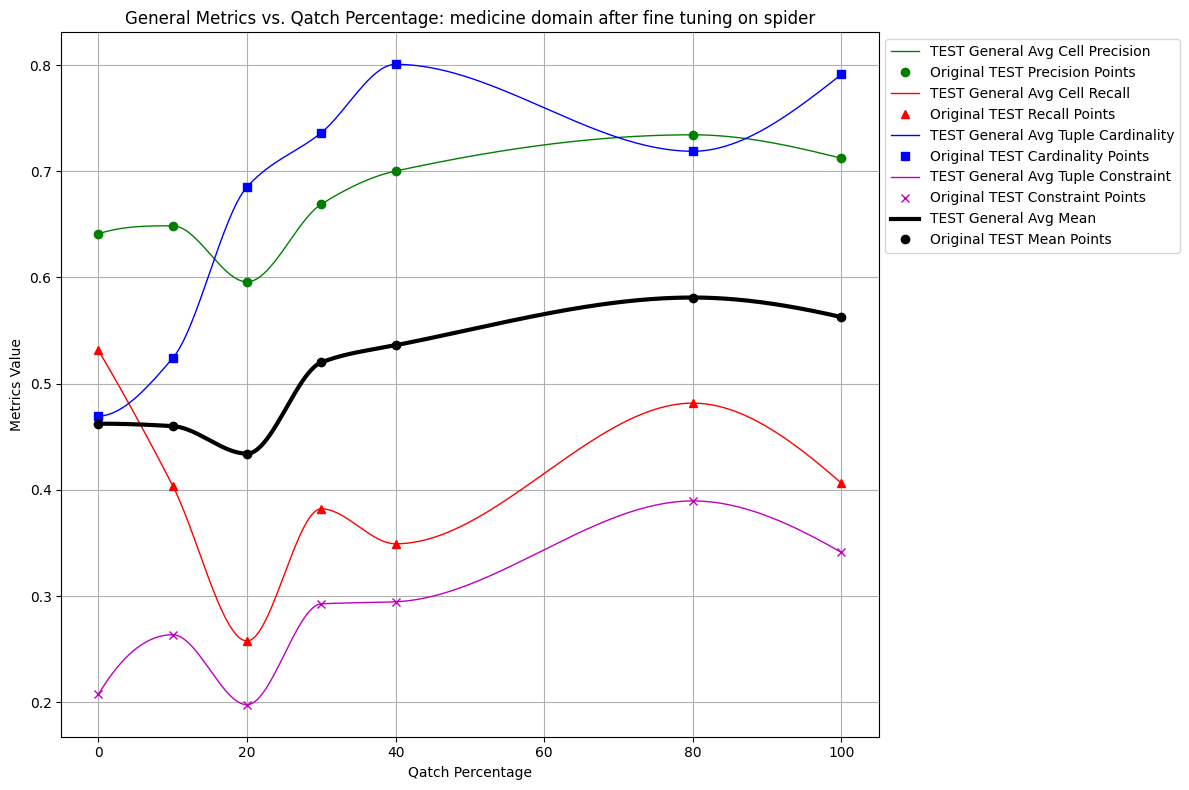

In [ ]:
#@title Medicine results after fine tuning on spider

base_path = '/content/drive/MyDrive/Tapas_SpiderPlusQatchProprietary_Logs/Medicine/results'
filename_pattern = 'Tapas_qatchMetrics_medicine{}prct_Test.csv'
percentages = [0,10, 20, 30,40,80, 100]## omit 60 its an outlier

combined_df_MedicineQatch = pd.DataFrame()
first_file_structure = None

for pct in percentages:
    file_path = os.path.join(base_path, filename_pattern.format(pct))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    current_df = pd.read_csv(file_path)
    current_df['qatch_percentage'] = pct
    if first_file_structure is None:
        first_file_structure = current_df.columns.tolist()
    else:
        if current_df.columns.tolist() != first_file_structure:
            print(f"File structure mismatch, skipping file: {file_path}")
            continue
    combined_df_MedicineQatch = pd.concat([combined_df_MedicineQatch, current_df], ignore_index=True)


columns_for_mean = ['general_avg_cell_precision', 'general_avg_cell_recall', 'general_avg_tuple_cardinality', 'general_avg_tuple_constraint']
combined_df_MedicineQatch['general_avg_mean'] = combined_df_MedicineQatch[columns_for_mean].mean(axis=1)



plt.figure(figsize=(12, 8))

# Ensure your data is sorted by 'qatch_percentage'
combined_df_MedicineQatch = combined_df_MedicineQatch.sort_values('qatch_percentage')
combined_df_MedicineQatch_High_Lr_exlusiveQatch=combined_df_MedicineQatch.copy()

# TEST data
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_precision'])
plt.plot(x_smooth, y_smooth, 'g-', label='TEST General Avg Cell Precision', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_precision'], 'go', label='Original TEST Precision Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_recall'])
plt.plot(x_smooth, y_smooth, 'r-', label='TEST General Avg Cell Recall', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_cell_recall'], 'r^', label='Original TEST Recall Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_cardinality'])
plt.plot(x_smooth, y_smooth, 'b-', label='TEST General Avg Tuple Cardinality', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_cardinality'], 'bs', label='Original TEST Cardinality Points')

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_constraint'])
plt.plot(x_smooth, y_smooth, 'm-', label='TEST General Avg Tuple Constraint', lw=1)
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_tuple_constraint'], 'mx', label='Original TEST Constraint Points')

# Plot the new column with more emphasis (e.g., thicker line)
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'])
plt.plot(x_smooth, y_smooth, 'k-', label='TEST General Avg Mean', lw=3)  # Increase line width for emphasis
plt.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'], 'ko', label='Original TEST Mean Points')



plt.title('General Metrics vs. Qatch Percentage: medicine domain after fine tuning on spider')
plt.xlabel('Qatch Percentage')
plt.ylabel('Metrics Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()

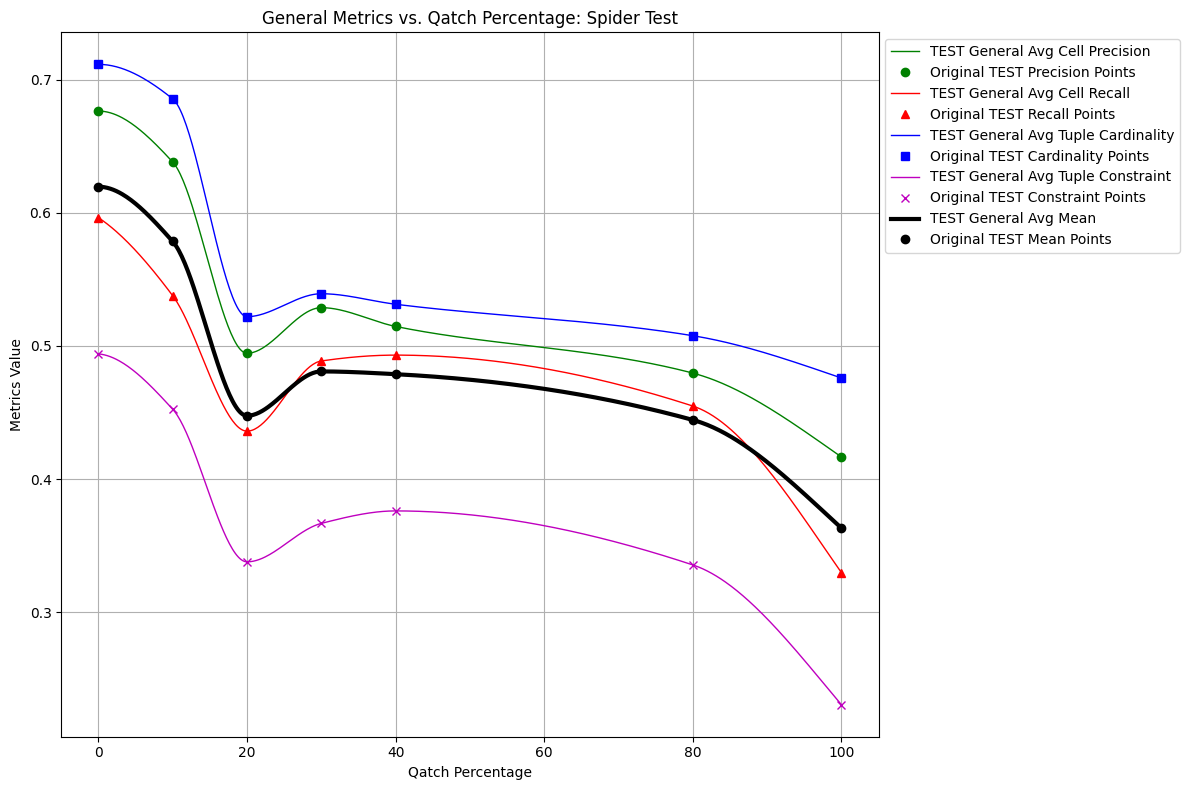

In [ ]:
#@title Spider test results after fine tuning on Medicine
base_path = '/content/drive/MyDrive/Tapas_SpiderPlusQatchProprietary_Logs/Medicine/results'
filename_pattern = 'Spider_test_QatchMetrics_Tapas{}prct.csv'
percentages = [0,10, 20, 30,40,80,100]## omit 60 its an outlier

combined_df_Medicine = pd.DataFrame()
first_file_structure = None

for pct in percentages:
    file_path = os.path.join(base_path, filename_pattern.format(pct))
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    current_df = pd.read_csv(file_path)
    current_df['qatch_percentage'] = pct
    if first_file_structure is None:
        first_file_structure = current_df.columns.tolist()
    else:
        if current_df.columns.tolist() != first_file_structure:
            print(f"File structure mismatch, skipping file: {file_path}")
            continue
    combined_df_Medicine = pd.concat([combined_df_Medicine, current_df], ignore_index=True)


columns_for_mean = ['general_avg_cell_precision', 'general_avg_cell_recall', 'general_avg_tuple_cardinality', 'general_avg_tuple_constraint']
combined_df_Medicine['general_avg_mean'] = combined_df_Medicine[columns_for_mean].mean(axis=1)


#@title Spider test
plt.figure(figsize=(12, 8))

# Ensure your data is sorted by 'qatch_percentage'
combined_df_Medicine = combined_df_Medicine.sort_values('qatch_percentage')
combined_df_Medicine_High_Lr_exlusive=combined_df_Medicine.copy()
# TEST data
x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_precision'])
plt.plot(x_smooth, y_smooth, 'g-', label='TEST General Avg Cell Precision', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_precision'], 'go', label='Original TEST Precision Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_recall'])
plt.plot(x_smooth, y_smooth, 'r-', label='TEST General Avg Cell Recall', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_cell_recall'], 'r^', label='Original TEST Recall Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_cardinality'])
plt.plot(x_smooth, y_smooth, 'b-', label='TEST General Avg Tuple Cardinality', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_cardinality'], 'bs', label='Original TEST Cardinality Points')

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_constraint'])
plt.plot(x_smooth, y_smooth, 'm-', label='TEST General Avg Tuple Constraint', lw=1)
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_tuple_constraint'], 'mx', label='Original TEST Constraint Points')

# Plot the new column with more emphasis (e.g., thicker line)
x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'])
plt.plot(x_smooth, y_smooth, 'k-', label='TEST General Avg Mean', lw=3)  # Increase line width for emphasis
plt.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'], 'ko', label='Original TEST Mean Points')


plt.title('General Metrics vs. Qatch Percentage: Spider Test')
plt.xlabel('Qatch Percentage')
plt.ylabel('Metrics Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for legend
plt.show()

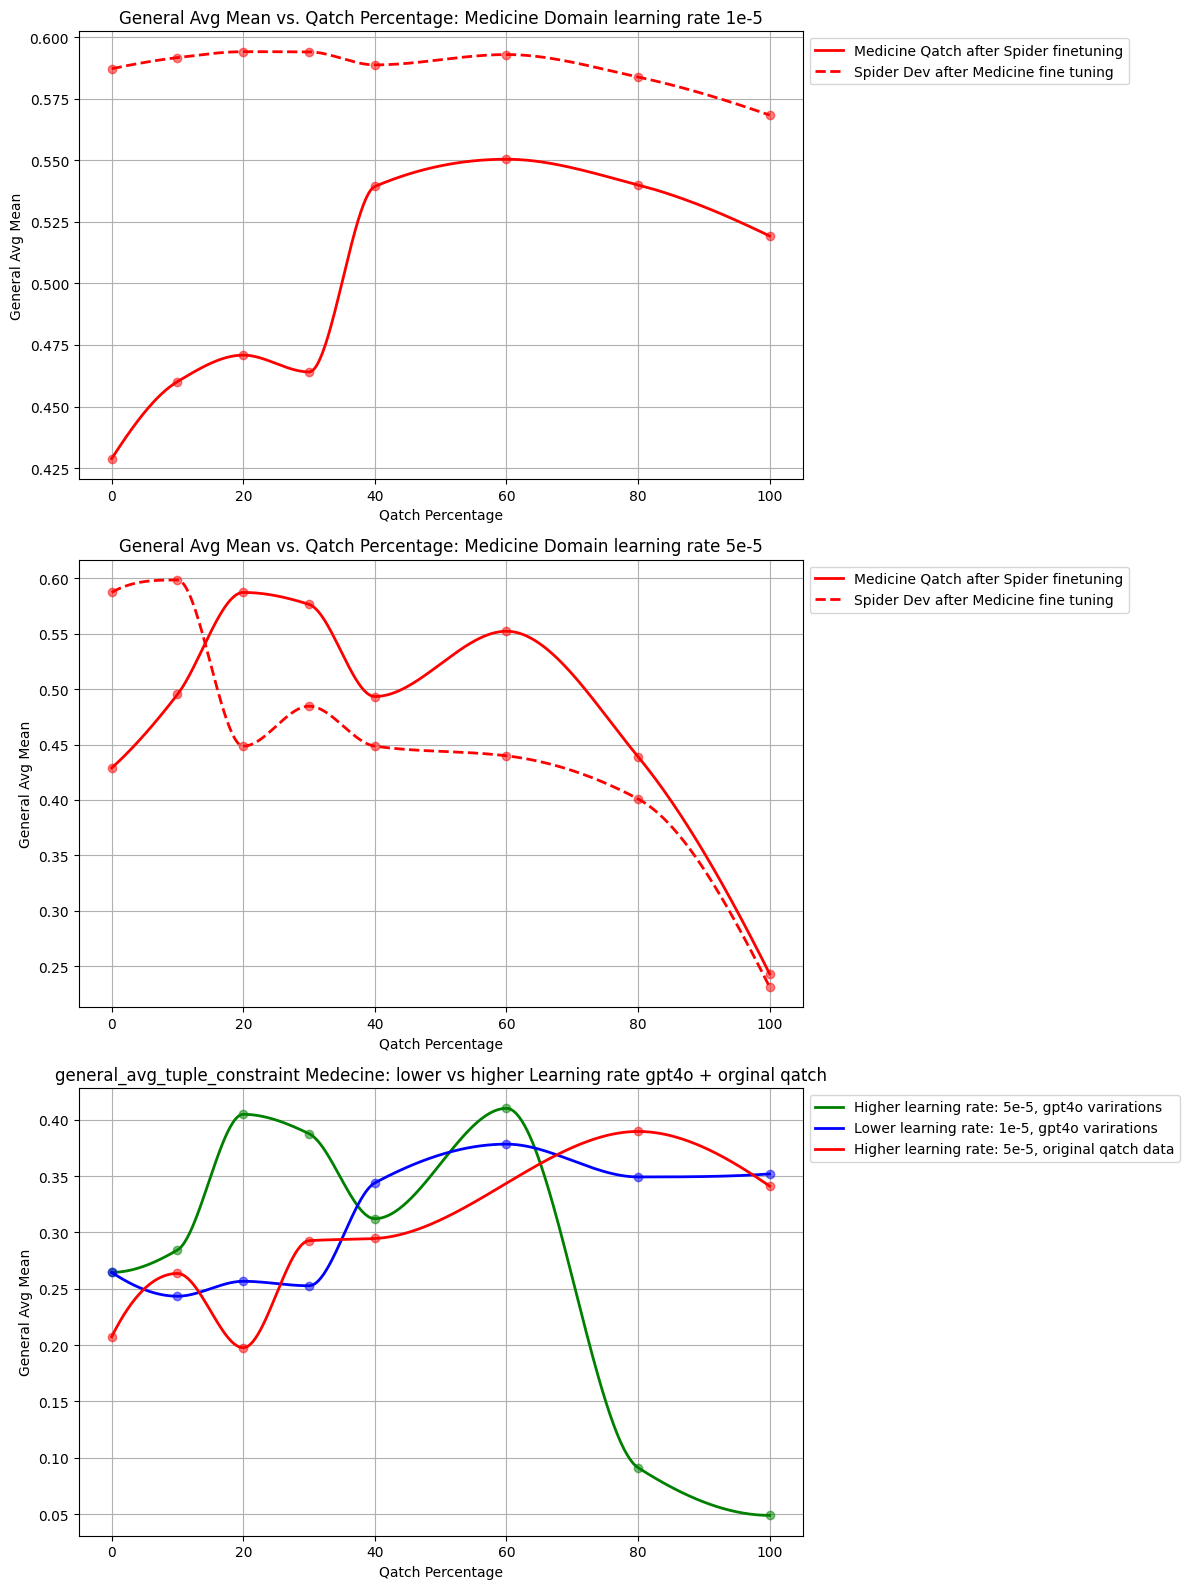

In [ ]:
# Plotting the data for each domain separately
fig, axs = plt.subplots(3, figsize=(12, 16))

combined_df_MedicineQatch=combined_df_MedicineQatch_Low_Lr.copy()
combined_df_Medicine=combined_df_Medicine_Low_Lr.copy()
# Medicine domain
ax = axs[0]
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'])
ax.plot(x_smooth, y_smooth, 'r-', label='Medicine Qatch after Spider finetuning', lw=2)
ax.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'], 'ro', alpha=0.5)

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'])
ax.plot(x_smooth, y_smooth, 'r--', label='Spider Dev after Medicine fine tuning', lw=2)
ax.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'], 'ro', alpha=0.5)

ax.set_title('General Avg Mean vs. Qatch Percentage: Medicine Domain learning rate 1e-5')
ax.set_xlabel('Qatch Percentage')
ax.set_ylabel('General Avg Mean')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True)


# Medicine domain

combined_df_MedicineQatch=combined_df_MedicineQatch_High_Lr.copy()
combined_df_Medicine=combined_df_Medicine_High_Lr.copy()
ax = axs[1]
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'])
ax.plot(x_smooth, y_smooth, 'r-', label='Medicine Qatch after Spider finetuning', lw=2)
ax.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'], 'ro', alpha=0.5)

x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'])
ax.plot(x_smooth, y_smooth, 'r--', label='Spider Dev after Medicine fine tuning', lw=2)
ax.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'], 'ro', alpha=0.5)

ax.set_title('General Avg Mean vs. Qatch Percentage: Medicine Domain learning rate 5e-5')
ax.set_xlabel('Qatch Percentage')
ax.set_ylabel('General Avg Mean')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True)





# Medicine domain

# combined_df_MedicineQatch=combined_df_MedicineQatch_High_Lr_exlusiveQatch.copy()
# combined_df_Medicine=combined_df_Medicine_High_Lr_exlusive.copy()
# ax = axs[2]
# x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'r-', label='Medicine Qatch after Spider finetuning', lw=2)
# ax.plot(combined_df_MedicineQatch['qatch_percentage'], combined_df_MedicineQatch['general_avg_mean'], 'ro', alpha=0.5)

# x_smooth, y_smooth = smooth_curve(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'r--', label='Spider Dev after Medicine fine tuning', lw=2)
# ax.plot(combined_df_Medicine['qatch_percentage'], combined_df_Medicine['general_avg_mean'], 'ro', alpha=0.5)

# ax.set_title('General Avg Mean vs. Qatch Percentage: Medicine Domain learning rate 5e-5, no gpt4o Original qatch data')
# ax.set_xlabel('Qatch Percentage')
# ax.set_ylabel('General Avg Mean')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.grid(True)



# ax = axs[3]
# x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch_High_Lr['qatch_percentage'], combined_df_MedicineQatch_High_Lr['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'g-', label='Higher learning rate: 5e-5, gpt4o varirations', lw=2)
# ax.plot(combined_df_MedicineQatch_High_Lr['qatch_percentage'], combined_df_MedicineQatch_High_Lr['general_avg_mean'], 'go', alpha=0.5)

# x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch_Low_Lr['qatch_percentage'], combined_df_MedicineQatch_Low_Lr['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'b-', label='Lower learning rate: 1e-5, gpt4o varirations', lw=2)
# ax.plot(combined_df_MedicineQatch_Low_Lr['qatch_percentage'], combined_df_MedicineQatch_Low_Lr['general_avg_mean'], 'bo', alpha=0.5)

# x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch_High_Lr_exlusiveQatch['qatch_percentage'], combined_df_MedicineQatch_High_Lr_exlusiveQatch['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'r-', label='Higher learning rate: 5e-5, original qatch data', lw=2)
# ax.plot(combined_df_MedicineQatch_High_Lr_exlusiveQatch['qatch_percentage'], combined_df_MedicineQatch_High_Lr_exlusiveQatch['general_avg_mean'], 'ro', alpha=0.5)

# ax.set_title('General Avg Mean vs. Qatch Percentage: Lower vs higher Learning rate gpt4o + orginal qatch')
# ax.set_xlabel('Qatch Percentage')
# ax.set_ylabel('General Avg Mean')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.grid(True)

##################

ax = axs[2]
x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch_High_Lr['qatch_percentage'], combined_df_MedicineQatch_High_Lr['general_avg_tuple_constraint'])
ax.plot(x_smooth, y_smooth, 'g-', label='Higher learning rate: 5e-5, gpt4o varirations', lw=2)
ax.plot(combined_df_MedicineQatch_High_Lr['qatch_percentage'], combined_df_MedicineQatch_High_Lr['general_avg_tuple_constraint'], 'go', alpha=0.5)

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch_Low_Lr['qatch_percentage'], combined_df_MedicineQatch_Low_Lr['general_avg_tuple_constraint'])
ax.plot(x_smooth, y_smooth, 'b-', label='Lower learning rate: 1e-5, gpt4o varirations', lw=2)
ax.plot(combined_df_MedicineQatch_Low_Lr['qatch_percentage'], combined_df_MedicineQatch_Low_Lr['general_avg_tuple_constraint'], 'bo', alpha=0.5)

x_smooth, y_smooth = smooth_curve(combined_df_MedicineQatch_High_Lr_exlusiveQatch['qatch_percentage'], combined_df_MedicineQatch_High_Lr_exlusiveQatch['general_avg_tuple_constraint'])
ax.plot(x_smooth, y_smooth, 'r-', label='Higher learning rate: 5e-5, original qatch data', lw=2)
ax.plot(combined_df_MedicineQatch_High_Lr_exlusiveQatch['qatch_percentage'], combined_df_MedicineQatch_High_Lr_exlusiveQatch['general_avg_tuple_constraint'], 'ro', alpha=0.5)

ax.set_title('general_avg_tuple_constraint Medecine: lower vs higher Learning rate gpt4o + orginal qatch')
ax.set_xlabel('Qatch Percentage')
ax.set_ylabel('General Avg Mean')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True)

# Miscellaneous domain
# ax = axs[1]
# x_smooth, y_smooth = smooth_curve(combined_df_MiscellaneousQatch['qatch_percentage'], combined_df_MiscellaneousQatch['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'g-', label='Miscellaneous Qatch after Spider finetuning', lw=2)
# ax.plot(combined_df_MiscellaneousQatch['qatch_percentage'], combined_df_MiscellaneousQatch['general_avg_mean'], 'go', alpha=0.5)

# x_smooth, y_smooth = smooth_curve(combined_df_Miscellaneous['qatch_percentage'], combined_df_Miscellaneous['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'g--', label='Spider Dev after Miscellaneous fine tuning', lw=2)
# ax.plot(combined_df_Miscellaneous['qatch_percentage'], combined_df_Miscellaneous['general_avg_mean'], 'go', alpha=0.5)

# ax.set_title('General Avg Mean vs. Qatch Percentage: Miscellaneous Domain')
# ax.set_xlabel('Qatch Percentage')
# ax.set_ylabel('General Avg Mean')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.grid(True)

# # Ecommerce domain
# ax = axs[2]
# x_smooth, y_smooth = smooth_curve(combined_df_EcommerceQatch['qatch_percentage'], combined_df_EcommerceQatch['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'b-', label='Ecommerce Qatch after Spider finetuning', lw=2)
# ax.plot(combined_df_EcommerceQatch['qatch_percentage'], combined_df_EcommerceQatch['general_avg_mean'], 'bo', alpha=0.5)

# x_smooth, y_smooth = smooth_curve(combined_df_Ecommerce['qatch_percentage'], combined_df_Ecommerce['general_avg_mean'])
# ax.plot(x_smooth, y_smooth, 'b--', label='Spider Dev after Ecommerce fine tuning', lw=2)
# ax.plot(combined_df_Ecommerce['qatch_percentage'], combined_df_Ecommerce['general_avg_mean'], 'bo', alpha=0.5)

# ax.set_title('General Avg Mean vs. Qatch Percentage: Ecommerce Domain')
# ax.set_xlabel('Qatch Percentage')
# ax.set_ylabel('General Avg Mean')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.grid(True)

plt.tight_layout()
plt.show()